In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import utl_eda
data_root = 'E:\\datasets\\tianchi\PAKDD\\hdf\\'

In [2]:
from  ml_utils import *

In [27]:
utl_eda.ID_COL = 'ID'
utl_eda.TARGET_COL = 'fault_01'
utl_eda.TIME_COL = 'dt'


# 只取出一个chunk进行分析


In [6]:
df_chunk = pd.read_hdf(data_root + 'disk_sample_smart_log_201707_0.h5')

df_chunk['dt'] = pd.to_datetime(df_chunk['dt'].astype(str), format='%Y%m%d')
df_chunk['ID'] =  df_chunk['model'].astype(str).str.cat(df_chunk['serial_number'], sep='_')

df_chunk = df_chunk.sort_values(['ID','dt'], ascending=True)

In [7]:
df_fault = pd.read_hdf(data_root + 'fault.h5')

In [8]:
df_fault.head()

,manufacturer,model,serial_number,fault_time,tag,ID
0,A,1,disk_100102,2017-09-29,0,1_disk_100102
1,A,1,disk_100584,2018-05-02,6,1_disk_100584
2,A,1,disk_100669,2018-06-22,3,1_disk_100669
3,A,1,disk_101190,2018-02-19,5,1_disk_101190
4,A,1,disk_103158,2017-10-20,0,1_disk_103158
...,...,...,...,...,...,...
1287,A,1,disk_41617,2018-05-15,1,1_disk_41617
1288,A,1,disk_41645,2018-04-27,1,1_disk_41645
1289,A,1,disk_42826,2018-02-11,0,1_disk_42826
1290,A,1,disk_429,2017-11-22,3,1_disk_429


# 给训练集打标签

In [10]:
df_chunk['fault_time'] = np.nan
df_chunk['fault_tag'] = np.nan

df_chunk['fault_time'] = df_chunk['fault_time'].astype('datetime64[ns]')



In [119]:
#df_chunk = df_chunk.drop('fault_days', axis=1)

In [11]:
for i in range(df_fault.shape[0]):
    row = df_fault.iloc[i]
    idxs = df_chunk[df_chunk['ID'] == row['ID']].index
    df_chunk.loc[idxs, 'fault_time'] = row['fault_time']
    df_chunk.loc[idxs, 'fault_tag'] = row['tag']
    df_chunk.loc[idxs, 'fault_days'] = (df_chunk.loc[idxs, 'fault_time'] - df_chunk.loc[idxs, 'dt']).dt.days

In [16]:
df_chunk.groupby(pd.cut(df_chunk['fault_days'], bins=(-999,-1, 0, 30, 999))).size()

fault_days
(-999, -1]       22
(-1, 0]          24
(0, 30]        1064
(30, 999]     10681
dtype: int64

In [28]:
df_chunk['fault_01'] = (df_chunk['fault_tag']>-1).astype(int)

In [30]:
df_chunk.groupby('fault_01').size()

fault_01
0    1598216
1      11791
dtype: int64

# 基本分析

## 目标变量分析

# 基本分析

In [12]:
df_chunk['fault_tag'] = df_chunk['fault_tag'].fillna(-1)

In [99]:
df_group.groupby('fault_tag').agg(['size', lambda x: len(x)*100/df_group.shape[0] ])

,size,<lambda_0>
fault_tag,,
0.0,270,0.262820
1.0,100,0.097341
2.0,137,0.133357
3.0,102,0.099287
4.0,42,0.040883
5.0,36,0.035043
6.0,102,0.099287
99.0,101943,99.231982


**目标变量极度不均衡**

In [14]:
df_chunk['fault_days'].fillna(9999, inplace=True)

In [15]:
df_chunk['fault_days'].describe()

count    1.610007e+06
mean     9.927211e+03
std      8.358594e+02
min     -1.000000e+00
25%      9.999000e+03
50%      9.999000e+03
75%      9.999000e+03
max      9.999000e+03
Name: fault_days, dtype: float64

In [140]:
# 相关性分析

In [17]:
smart_col = [c for c in df_chunk.columns if c.startswith('smart')]

In [37]:
ser_corr = df_chunk[['fault_01'] + smart_col  ].corr()['fault_01']

In [38]:
ser_corr.abs().sort_values()

smart_12_normalized     0.000102
smart_3raw              0.000178
smart_12raw             0.000279
smart_192_normalized    0.000318
smart_10_normalized     0.000400
smart_191raw            0.000430
smart_10raw             0.000470
smart_199_normalized    0.000482
smart_199raw            0.000489
smart_192raw            0.000790
smart_184_normalized    0.000890
smart_7raw              0.000909
smart_184raw            0.001006
smart_188raw            0.001048
smart_189raw            0.001079
smart_187raw            0.001382
smart_4_normalized      0.001516
smart_193raw            0.001913
smart_195raw            0.002680
smart_1raw              0.003040
smart_188_normalized    0.003213
smart_4raw              0.004119
smart_193_normalized    0.005272
smart_1_normalized      0.006662
smart_190raw            0.006812
smart_194_normalized    0.007223
smart_194raw            0.007223
smart_189_normalized    0.007447
smart_5raw              0.008198
smart_197raw            0.008533
smart_198r

## 分析smart_187_normalized

In [20]:
def print_hist(df, col, bins=10):
    cut = pd.cut(df[col], bins)
    return df.groupby(cut).size()

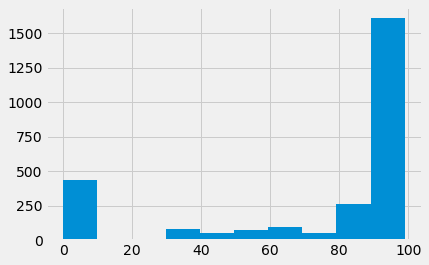

In [24]:
df_chunk[df_chunk['smart_187_normalized']<100]['smart_187_normalized'].hist()

In [25]:
print_hist(df_chunk,'smart_187_normalized',10)

smart_187_normalized
(-0.1, 10.0]         435
(10.0, 20.0]           4
(20.0, 30.0]          19
(30.0, 40.0]          63
(40.0, 50.0]          58
(50.0, 60.0]          91
(60.0, 70.0]          76
(70.0, 80.0]          86
(80.0, 90.0]         240
(90.0, 100.0]    1608935
dtype: int64

The correlation between smart_187_normalized and the TARGET is 0.0241
Median value for Target==1  = 97.0000
Median value for Target==0  = 94.0000


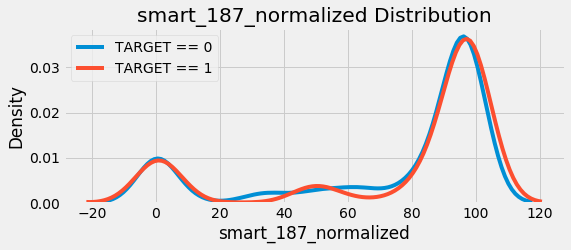

In [33]:
utl_eda.kde_target(df_chunk[df_chunk['smart_187_normalized']<100], 'smart_187_normalized')

# smart_7_normalized

In [35]:
var = 'smart_7_normalized'
print_hist(df_chunk,var,10)

smart_7_normalized
(40.941, 46.9]       195
(46.9, 52.8]          41
(52.8, 58.7]         174
(58.7, 64.6]        8355
(64.6, 70.5]       21916
(70.5, 76.4]       32428
(76.4, 82.3]       93002
(82.3, 88.2]      514998
(88.2, 94.1]      846587
(94.1, 100.0]      92311
dtype: int64

The correlation between smart_7_normalized and the TARGET is -0.0235
Median value for Target==1  = 88.0000
Median value for Target==0  = 90.0000


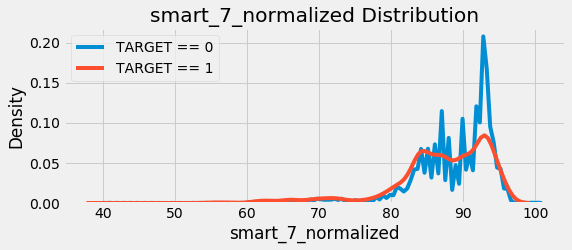

In [36]:
utl_eda.kde_target(df_chunk, var)

In [ ]:
## smart_5_normalized

In [39]:
var = 'smart_5_normalized'
print_hist(df_chunk,var,10)

smart_5_normalized
(-0.1, 10.0]         209
(10.0, 20.0]          19
(20.0, 30.0]          20
(30.0, 40.0]           2
(40.0, 50.0]          77
(50.0, 60.0]          30
(60.0, 70.0]          23
(70.0, 80.0]         164
(80.0, 90.0]         209
(90.0, 100.0]    1609254
dtype: int64

The correlation between smart_5_normalized and the TARGET is 0.1112
Median value for Target==1  = 97.0000
Median value for Target==0  = 97.0000


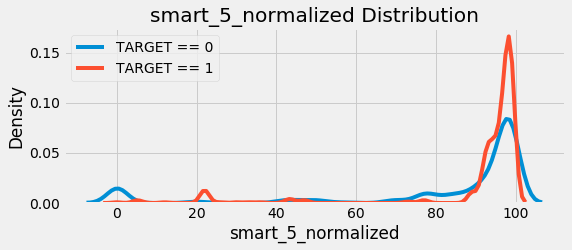

In [40]:
utl_eda.kde_target(df_chunk[df_chunk[var]<100], var)

In [ ]:
smart_9raw

In [41]:

var = 'smart_9raw'
print_hist(df_chunk,var,10)

smart_9raw
(-73.165, 7821.5]     214876
(7821.5, 15638.0]     369396
(15638.0, 23454.5]    495826
(23454.5, 31271.0]    517740
(31271.0, 39087.5]     12157
(39087.5, 46904.0]         0
(46904.0, 54720.5]         0
(54720.5, 62537.0]         0
(62537.0, 70353.5]         0
(70353.5, 78170.0]        12
dtype: int64

The correlation between smart_9raw and the TARGET is -0.0181
Median value for Target==1  = 16944.0000
Median value for Target==0  = 18984.0000


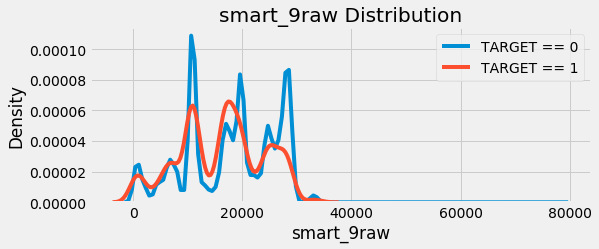

In [42]:
utl_eda.kde_target(df_chunk, var)